# Bayesian Statistics

**Bayes' Regression**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1)
%matplotlib inline

In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2
'''
noisydata

'''

'\nnoisydata\n\n'

In [4]:
reg = np.polyfit(x, y, 1) #OLS regression

In [5]:
reg

array([1.9894297 , 4.15972527])

Text(0, 0.5, 'y')

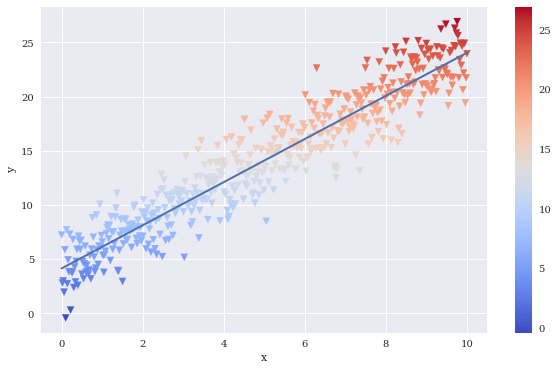

In [6]:
plt.figure(figsize = (10, 6))
plt.scatter(x, y, c = y, marker = 'v', cmap = 'coolwarm')
plt.plot(x, reg[1] + reg[0] * x, lw = 2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

In [7]:
import pymc3 as pm

In [8]:
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sd=20)  
    beta = pm.Normal('beta', mu=0, sd=10)  
    sigma = pm.Uniform('sigma', lower=0, upper=10)  
    y_est = alpha + beta * x  
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)  

    # inference
    start = pm.find_MAP()  #始点を探してくれる
    step = pm.NUTS()  #efficient No-U-Turn Sampler with dual averaging; アルゴリズムの一種
    trace = pm.sample(100, tune=1000, start=start, progressbar=True, verbose=False) #上記二つより得られるサンプル

AttributeError: module 'numpy.core.multiarray' has no attribute '_get_ndarray_c_version'

**Two Financial Instruments**

In [9]:
raw = pd.read_csv('datas/tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)

In [10]:
data = raw[['GDX', 'GLD']].dropna()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2010-01-04 to 2017-10-31
Data columns (total 2 columns):
GDX    1972 non-null float64
GLD    1972 non-null float64
dtypes: float64(2)
memory usage: 46.2 KB


In [19]:
data.ix[-1] / data.ix[0] - 1

/Users/norihito_kita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


GDX   -0.528820
GLD    0.098998
dtype: float64

In [13]:
data.corr()

,GDX,GLD
GDX,1.000000,0.715185
GLD,0.715185,1.000000


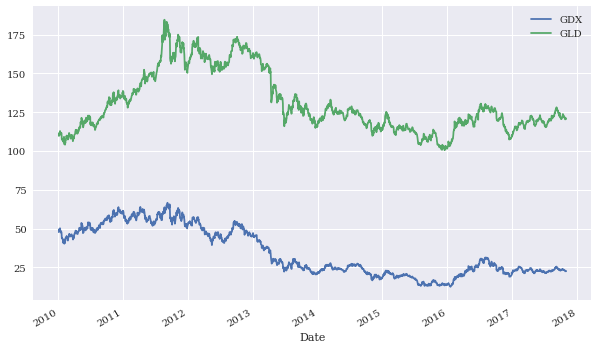

In [14]:
data.plot(figsize = (10, 6))

In [15]:
data.index[:3]

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06'], dtype='datetime64[ns]', name='Date', freq=None)

In [16]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime()) #日付をmpl用に
mpl_dates[:3]

array([733776., 733777., 733778.])

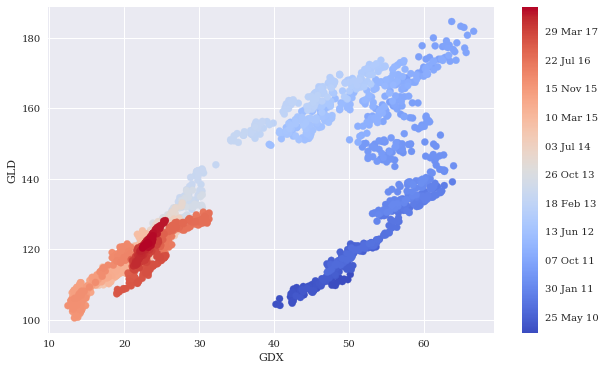

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

In [20]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    y_est = alpha + beta * data['GDX'].values

    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma, observed = data['GLD'].values)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(250, tune=2000, start=start, progressbar=True)

AttributeError: module 'numpy.core.multiarray' has no attribute '_get_ndarray_c_version'

**Updating Estimate over Time**

In [21]:
from pymc3.distributions.timeseries import GaussianRandomWalk

In [22]:
subsample_alpha = 50
subsample_beta = 50

In [23]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sig_alpha', 1. / .02, testval = .1)
    sigma_beta = pm.Exponential('sig_beta', 1. / .02, testval = .1)
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2, shape = int(len(data) / subsample_alpha))
    beta = GaussianRandomWalk('beta', sigma_beta ** -2, shape = int(len(data) / subsample_beta))
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)
    regression = alpha_r ; beta_r : data['GDX'].values[:2100]
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD', muregression, sd = sd, observed = data['GLD'].values[:2100])    

AttributeError: module 'numpy.core.multiarray' has no attribute '_get_ndarray_c_version'

In [24]:
%%time
import scipy.optimize as sco
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta], fmin=sco.fmin_l_bfgs_b)
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(250, tune=1000, start=start, progressbar=True)

NameError: name 'alpha' is not defined

NameError: name 'sh' is not defined

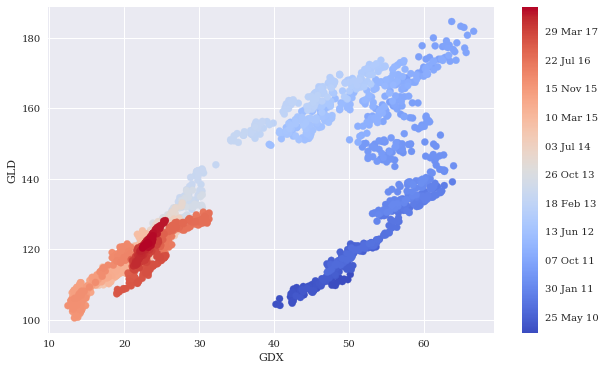

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o', cmap='coolwarm')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX']))
for i in range(sh[1]):  
    alpha_rw = np.mean(trace_rw['alpha'].T[i])
    beta_rw = np.mean(trace_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, '--', lw=0.7, color=plt.cm.coolwarm(i / sh[1]))